# Finding the 2D $Y$-$E_r$ Distributions Given Arvind's Yield Dist

Arvind has calculated 1-dimensional yield distributions for a given recoil energy, $E_r$. For some of the analysis of the NR Fano paper we would like to know the 2-dimensional distribution in the Yield-Recoil plane. I try to begin calculating that below, first for the $E_p$/$E_q$ plane. 

## The $E_p$/$E_q$ Plane

The joint distribution can be described in terms of the conditional distribution as follows (See [Wikipedia Article][WikiJoint]): 

\begin{equation}
P(E_p,E_q) = P(E_p | E_q) P(E_q)
\end{equation}

[WikiJoint]: https://en.wikipedia.org/wiki/Conditional_probability_distribution "Wikipedia Article on Joint Distribution" 

In [1]:
import numpy as np

#construct the functions

#constants
V = 4.0
eps = 3.3/1000 #in keV/pair
sigq = 1.0
sigp = 1.0
F = 10.0

#yield
a = 0.00751668
b = 0.40236176

#y = lambda x: a*x**b
y = lambda x: 1

#Guassian for phonon fluctuation
gp = lambda Ep,Eq,N,Er: (1/np.sqrt(2*np.pi*sigp))*np.exp(-(Er-Ep+(V/eps)*Eq+(V/eps)*(Eq-eps*N))**2/(2*sigp**2))

#Gaussian for charge fluctuation
gq = lambda Ep,Eq,N,Er: (1/np.sqrt(2*np.pi*sigq))*np.exp(-(Eq-eps*N)**2/(2*sigq**2))

#Gaussian for N fluctuation
gN = lambda Ep,Eq,N,Er: (1/np.sqrt(2*np.pi*np.sqrt(F*(Er*y(Er)/eps))))*np.exp(-(N-(Er*y(Er)/eps))**2/(2*F*(Er*y(Er)/eps)))

In [2]:
#generate a set of reasonable parameters
Er0 = 10
N0 = Er0*y(Er0)/eps
Ep0 = Er0 + V*N0
Eq0 = eps*N0

print(gN(Ep0,Eq0,N0,Er0))
print(gp(Ep0,Eq0,N0,Er0))
print(gq(Ep0,Eq0,N0,Er0))

0.03023698961698382
0.3989422804014327
0.3989422804014327


In [3]:
#get the distribution in Er, use a simple exponential for now

alpha = 1/10 #that means will be down by a factor of e at 10 keV

per = lambda Er: alpha*np.exp(-alpha*Er)

In [4]:
#stitch these things together to make one nasty function
p4d = lambda Ep,Eq,N,Er: gp(Ep,Eq,N,Er)*gq(Ep,Eq,N,Er)*gN(Ep,Eq,N,Er)*per(Er)

In [5]:
print(p4d(Ep0,Eq0,N0,Er0))

0.00017703706478769906


In [6]:
#now have to integrate some stuff
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.integrate import quadrature

 #integrate
#f = lambda x,m: ((np.exp(-np.power(x/r_0, (1/n))))*(np.power(x/r_0, ((1/n)-1))))/(np.sqrt((x**2)-(m**2)));
igrnd = lambda Er,Ep,Eq,N: p4d(Ep,Eq,N,Er) #just switching the args around for integration
print(per(0))
print(igrnd(60,Ep0,Eq0,N0))
I = quad(igrnd, 0.001, 125,args=(Ep0,Eq0,N0,))

print(I)

0.1
0.0
(0.00022073498827540524, 3.115059543821583e-10)


In [7]:
#test out the plotting 
#set up a plot 
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

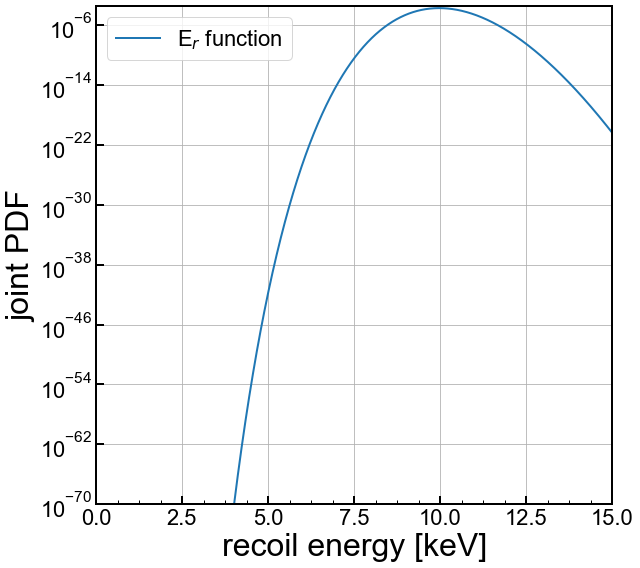

In [8]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

ingrndv = np.vectorize(lambda x: igrnd(x,Ep0,Eq0,N0))
x = np.arange(0.1,15,0.01)

#plot quick
#fig = plt.figure()
#ax1 = fig.add_subplot(111)
ax1.plot(x, ingrndv(x),label='E$_r$ function')


ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlim(0, 15) 
ax1.set_ylim(1e-70,3e-4)
ax1.set_xlabel('recoil energy [keV]',**axis_font)
ax1.set_ylabel('joint PDF',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=2,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

In [9]:
#try to get the support
import scipy

def get_support(f):
  #max_x = scipy.optimize.fmin(f, 3)
  max_x = scipy.optimize.minimize_scalar(f,bounds=[0.1,15],method='bounded')
  #max_x = scipy.optimize.minimize_scalar(f,method='brent')
  print(max_x)
  return

#get_support(lambda x:np.exp(-x^2))
#def f(x): return -2 * x**2 + 4 * x
#ax_x = scipy.optimize.fmin(lambda x: -f(x), 0)
#print(max_x)
#get_support(lambda x: -f(x))
#get_support(lambda x: -np.exp(-x**2))
get_support(lambda x: -np.log(igrnd(x,Ep0,Eq0,N0)+1))
print(-np.log(igrnd(10,Ep0,Eq0,N0)+1))

     fun: -0.00017736425561065754
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 9.969073972522501
-0.00017702139557594982


In [10]:
#play with double integral
igrnd = lambda Er,N,Ep,Eq: p4d(Ep,Eq,N,Er)
igrnd_alt = lambda N,Er,Ep,Eq: p4d(Ep,Eq,N,Er)
result = integrate.quad(igrnd, 0.1, 15,args=(N0,Ep0,Eq0,))
print(result)
result = integrate.quad(igrnd_alt, 3025, 3035,args=(10,Ep0,Eq0,))
print(result)
result = integrate.dblquad(igrnd, 9.9, 10.1, 3025, 3035,args=(Ep0,Eq0,))
print(result)

(0.0002207349882754401, 1.0064765943854741e-11)
(0.00011094137590061694, 2.615853107351895e-09)
(0.0, 0)


3030.3030303030305
0.00017703706478769906


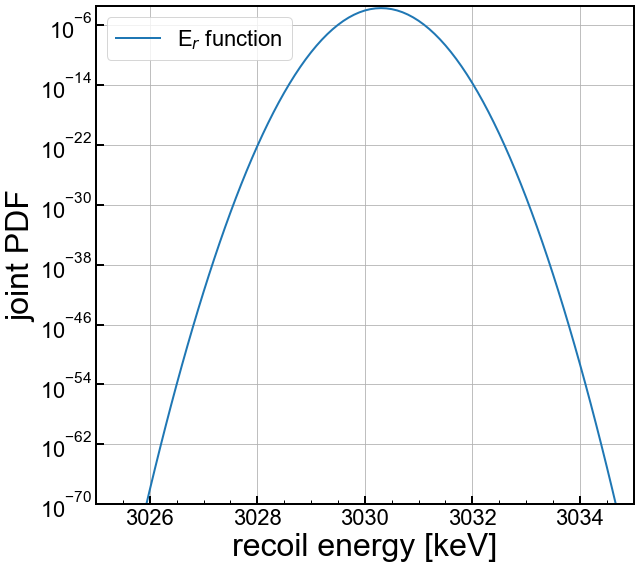

In [11]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

print(N0)
print(igrnd_alt(N0,10,Ep0,Eq0))
ingrndv_alt = np.vectorize(lambda x: igrnd_alt(x,10,Ep0,Eq0))
x = np.arange(3025,3035,0.1)

#plot quick
#fig = plt.figure()
#ax1 = fig.add_subplot(111)
ax1.plot(x, ingrndv_alt(x),label='E$_r$ function')


ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlim(3025, 3035) 
ax1.set_ylim(1e-70,3e-4)
ax1.set_xlabel('recoil energy [keV]',**axis_font)
ax1.set_ylabel('joint PDF',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=2,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

In [12]:
#let's try to get a look at a contour plot
xg = np.linspace(9.0, 11.0, 50)
yg = np.linspace(3025, 3035, 50)

X, Y = np.meshgrid(xg, yg)
igrnd_cont = lambda Er,N: p4d(Ep0,Eq0,N,Er)
igrnd_cont_v = np.vectorize(igrnd_cont)
print(p4d(Ep0,Eq0,3030,10))
Z = igrnd_cont_v(X,Y)

8.492242431453667e-05


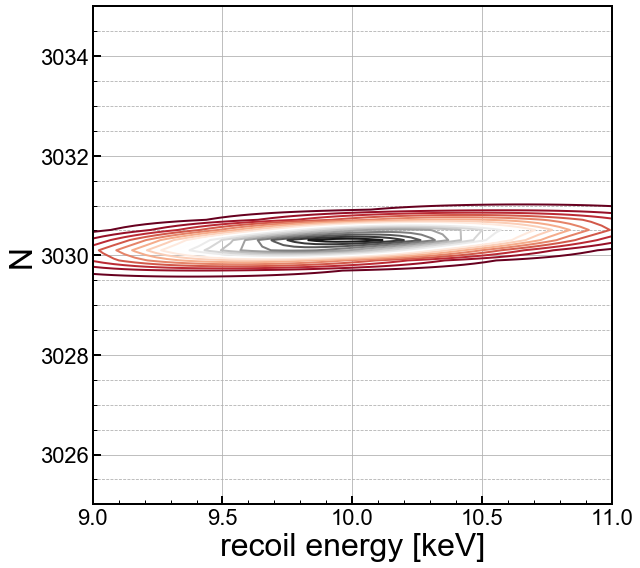

In [13]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes



#plot quick
#fig = plt.figure()
#ax1 = fig.add_subplot(111)
#ax1.plot(x, ingrndv_alt(x),label='E$_r$ function')
#ax1.contour(X, Y, Z, colors='black',label='E$_r$/N')
ax1.contour(X, Y, Z, 20,cmap='RdGy');


ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlim(9.0, 11.0) 
ax1.set_ylim(3025,3035)
ax1.set_xlabel('recoil energy [keV]',**axis_font)
ax1.set_ylabel('N',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend(loc=2,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()